In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

# Overview

This project uses WENO reconstruction (first described in [this paper](https://www.sciencedirect.com/science/article/pii/S0021999184711879)) to get high order accurate solutions to the 1D Euler gas equations (modeling gas in a tube).

WENO gives us higher order accuracy without being too complicated to implement. We consider two instances of gas in a tube and see how its state variables evolve over time. We verify 3rd order accuracy in regions away from shocks/discontinuities when the solution is known exactly, and then we run the solver on a case that develops a shock.

In the first instance, density as a function of x (x = length along the tube) is a sinusoid (1 + 0.5 sin(2pix)), and the initial pressure and energy are some constant everywhere. Under these conditions the pressure and velocity should never change and the density should return periodically to the initial distribution. The code here tests the dependence of the error on spacing to confirm that WENO reconstruction gives us 3rd order accuracy.

Having verified accuracy, the second instance we consider is the Sod problem, described [here](https://www.astro.uu.se/~hoefner/astro/teach/ch10.pdf) (ref \#2). Initially, the tube is such that there are two adjacent regions of different pressure separated by a thin film or boundary. When those regions are suddenly freely allowed to interact, we get a shock wave and the expected solutions are described in the previous link. We graph the solutions obtained by our solver (they match the link and have unusual shapes).

The way we use WENO matches the description of the original paper, but we also project in and out of characteristic variables of the system of equations. Details of weno with characteristics used here follow the reference [here](http://math.tifrbng.res.in/~praveen/pub/ncm2019.pdf) (ref \#3)

## Physics helper functions and WENO reconstruction

We next implement necessary functions to define relationships between the physical quantities in question and set up the WENO reconstruction, Local-Lax-Friedrichs flux function, and a 3rd order runge-kutta solver for the problem.

In [55]:
#constants
GAMMA = 1.4 #adiabatic constant for diatomic gas

# given a tuple of conserved vars (r, ru, E), returns r(density), u (velocity), p (pressure), E (energy)
def get_state(cons_vars):
    rho = cons_vars[0] #density
    rho_u = cons_vars[1] #density*velocity
    energy_density = cons_vars[2] #energy per unit volume
    vel = rho_u/rho #velocity
    pressure = (GAMMA - 1)*(energy_density - 0.5*rho*vel**2) #caloric equation of state
    sound_speed = (1.4*pressure/rho)**0.5 #speed of sound in the medium
    return rho,vel,pressure,energy_density,sound_speed

#the function F for which the equations look like v_t + (F(v))_x = 0 (underscores = partial derivatives)
#Here v = a tuple of (r, ru, e) with r = density, u = velocity, e = energy density [conserved variables]
#Each of r,u,e are differentiable functions : (x,t) -> reals
def physical_flux(cons_var_vec):
    rho_vec = cons_var_vec[0,:]
    rho_u_vec = cons_var_vec[1,:] 
    energy_density_vec = cons_var_vec[2,:]
    vel_vec = np.multiply(rho_u_vec,rho_vec**-1.0) #velocity
    pressure_vec = (GAMMA - 1)*(energy_density_vec - 0.5*np.multiply(rho_vec,vel_vec**2)) #caloric equation of state - pressure
    #returning F(r,ru,e)
    f_cons = np.zeros((3,cons_var_vec.shape[1]),dtype=np.float64)
    f_cons[0,:] = rho_u_vec
    f_cons[1,:] = pressure_vec + rho_vec*vel_vec**2
    f_cons[2,:] = np.multiply(energy_density_vec + pressure_vec, vel_vec)
    return f_cons

# Motivation (characteristic variables):
# each of r, u, e are functions from (x,t) ->  R (real numbers)
# set r,u,e to be coordinate functions of v(x,t) :R^2 -> R^3
# We started with this equation:
# (F_v)(v(x(t),t))_x + v(x(t),t)_t = 0 (Here F_v is the Jacobian of F:R^3->R^3 above)
# Suppose F_v is diagonalized as R D R^-1
# Along characteristic curves in each variable, R,D are constant and we can write:
# D (R^-1 v(x(t),t)_x + (R^-1 v(x(t),t))_t = 0
# So in the transformed coordinates R^-1(v), we have cleanly separated hyperbolic equations

# returns R in above description from characteristic vars -> conserved vars
# (matrix chosen here matches ref #3)
def char_to_cons(cons_vars):
    rho, vel, pressure, energy_density, sound_speed = get_state(cons_vars)
    enthalpy = (energy_density + pressure)/rho
    
    #change of basis matrix
    char_to_cons = np.zeros((3,3),dtype=np.float64)
    char_to_cons[0] = np.array([1.0,1.0,1.0])
    char_to_cons[1] = np.array([vel - sound_speed,vel,vel + sound_speed])
    char_to_cons[2] = np.array([enthalpy - vel*sound_speed, 0.5*vel**2, enthalpy + vel*sound_speed])
    return char_to_cons

#returns R^-1 in above description from conserved vars -> characteristic vars:
#matrix chosen matches ref #3 (and inverse of above choice)
def cons_to_chars(cons_vars):
    #extracting density, density*velocity, energy as before
    rho, vel, pressure, energy_density, sound_speed = get_state(cons_vars)
    #not physical vars, but precomputing makes expressions involved simpler
    a_inv = 1/sound_speed
    a_inv_sq = a_inv/sound_speed
    vel_to_sound = vel/sound_speed
    gam_a_inv_sq = 0.5*(GAMMA - 1)*a_inv_sq
    
    cons_to_char = np.zeros((3,3),dtype=np.float64)
    cons_to_char[0] = np.array([gam_a_inv_sq*vel*vel*0.5 + 0.5*vel_to_sound, -gam_a_inv_sq*vel - 0.5*a_inv, gam_a_inv_sq])
    cons_to_char[1] = np.array([1.0 - gam_a_inv_sq*vel*vel, gam_a_inv_sq*2*vel, -gam_a_inv_sq*2])
    cons_to_char[2] = np.array([gam_a_inv_sq*vel*vel*0.5 - 0.5*vel_to_sound, -gam_a_inv_sq*vel + 0.5*a_inv, gam_a_inv_sq])
    return cons_to_char

In [48]:
#the 3-order WENO reconstruction function, which takes cell averages (v0, v1, v2) and the derivative (d)
#returns a reconstructed 
def weno3(v0,v1,v2,d):
    #v0, v1, v2 are the three estimates from three different stencils around the point in question
    #d is the derivative which helps us decide which way to weight
    p0 = 1.5*v1 - 0.5*v0 #polynomials evaluated at the point
    p1 = 0.5*(v1 + v2)
    b0 = (v1 - v0)**2 #smoothing factors
    b1 = (v2 - v1)**2
    eps = 1e-7 #to avoid degeneracies
    weno_approx = np.zeros(3,dtype=np.float64)
    for i in range(3):
        if d[i] >= 0: 
            a0 = 0.5/((eps + b0[i])**2)
            a1 = 1.0/((eps + b1[i])**2)
        else:
            a0 = 1.0/((eps + b0[i])**2)
            a1 = 0.5/((eps + b1[i])**2)
        weno_approx[i] = (a0*p0[i] + a1*p1[i])/(a0 + a1)
    return weno_approx

#will be done using the characteristics
#this is the all important reconstruction function, that computes the characteristics and stencils
#and then passes them to the WENO3 function to get 3rd order estimates. Then it undoes the characteristic
#transformation and passes the left and right cell estimates to the Lax-Friedrichs function, along with
#information about the derivative everywhere (which is necessary)
def reconstruct(v,b):
    n = v.shape[1]
    vl = np.zeros((3,n+1),dtype=np.float64) #the left endpoints for lax friedrichs
    vr = np.zeros((3,n+1),dtype=np.float64) #the right endpoint for lax friedrichs
    lams = np.zeros(n+1,dtype=np.float64) #where we will store information about the derivatives
    for i in range(n+1): #at cell i, we need four points around it to get three stencils of three points each
        indl = i - 2 #index of point to the left
        ind = i - 1 #index of the point
        indr = i #index of the point to the right
        indr2 = i+1 #index of point two steps to the right
        
        if b == "p":
            #periodic bcs = move overshoots to other end
            if indl < 0:
                indl = indl + n
            if ind < 0:
                ind = ind + n
            if indr >= n:
                indr = indr - n
            if indr2 >= n:
                indr2 = indr2 - n
        else:
            #otherwise these are handled after all interior pts
            if indl < 0 or ind < 0 or indr >=n or indr2 >=n:
                continue

        #compute basis for characteristics
        v_h = 0.5*(v[:,ind] + v[:,indr]) #pick average at 
        r_h = char_to_cons(v_h)
        l_h = cons_to_chars(v_h)
        
        #the characteristic speeds at the point are u-a, u, u + a, u = velocity, a = speed of sound at the point
        #the maximum of these speeds is information we need for the lax-friedrichs function later
        _, left_u, _ , _ , left_a = get_state(v[:,ind])
        _, right_u,_, _, right_a = get_state(v[:,indr])
        dl = np.array([left_u - left_a, left_u, left_u + left_a])
        dr = np.array([right_u - right_a, right_u, right_u + right_a])
        
        #now weno reconstructing on the characteristics using the inverse transformation that takes us into char space
        w0 = np.dot(l_h,v[:,indl])
        w1 = np.dot(l_h,v[:,ind])
        w2 = np.dot(l_h,v[:,indr])
        w3 = np.dot(l_h,v[:,indr2])
        ret1 = weno3(w0,w1,w2,dl) #3rd order WENO function for the left estimate
        ret2 = weno3(w3,w2,w1,dr) #3rd order WENO for the right estimate
        
        #undoing the coordinate transformation back into local coordinates
        vl[:,i] = np.dot(r_h,ret1)
        vr[:,i] = np.dot(r_h,ret2)
        lams[i] = np.max(np.array([np.max(np.abs(dl)),np.max(np.abs(dr))])) #remembering max char speed for LLF

    #third order bcs for neumann conditions
    if b == "n":
        for vx in [vl, vr]: 
            vx[:,0] = (4*vx[:,2] - vx[:,4])/3
            vx[:,1] = (3*vx[:,0] + vx[:,2])/4
            vx[:,n] = (4*vx[:,n-3] - vx[:,n-6])/3
            vx[:,n-2] = (3*vx[:,n] + vx[:,n-4])/4
            vx[:,n-1] = (3*vx[:,n] + vx[:,n-2])/4
        lams[[0,1,n,n-1]] = np.max(lams)
        
    return vl, vr, lams

In [49]:
#computes the monotone flux at cell boundaries and returns the largest 
def numeric_flux_and_eigval(v,b):
    vl, vr, lams = reconstruct(v,b)
    f_vr = physical_flux(vr)
    f_vl = physical_flux(vl)
    diffs = 0.5*np.multiply(lams,vr - vl)
    retval = 0.5*(f_vr + f_vl) - diffs
    return retval, np.max(lams) #the maximum derivative is needed for Local Lax Friedrich's combination parameter

In [50]:
#L = difference of the lax friedrichs function at adjacent points
#typically the hyperbolic conservation law equation is just v_new = v + param*(L), here lam = param
def L(v,b):
    ns = v.shape[1]
    dx = 1.0/ns
    f, lam = numeric_flux_and_eigval(v,b)
    retval = -1.0*(f[:,1:] - f[:,0:-1])/dx
    return retval, lam

In [51]:
#finally using the L function above with a 3rd order accurate Runge-Kutta method
#uses the v = v_old + lam*L finite volume equation
def solve(ics, b, T):
    t = 0
    v = np.copy(ics)
    n = v.shape[1]
    dx = 1.0/n
    while t < T:
        L0, lam = L(v,b)
        dt = min(1.0/(n*lam),1.0/n)
        v1 = v + dt*L0
        L1, lam = L(v1,b)
        v2 = 0.75*v + 0.25*(v1 + dt*L1)
        L2, lam = L(v2,b)
        v = (v/3.0) + 2*(v2 + dt*L2)/3.0
        t = t + dt
    return v

## Defining initial conditions

We make initial conditions for both the sod problem and the advection problem.

For advection density varies as 1 + 0.5 sin(2pi\*x) over the tube, and velocity, energy are some constant.
Our vector is (density, density\*velocity, energy) in the primitive variables

For the sod problem density "r" is two constant regions with an abrupt drop between them, u = 0, and energy abruptly shifts between the two regions (related to pressure by a factor of 1/(gam-1)).

In [52]:
def make_per_ics(n):
    retval = np.zeros((3,n),dtype=np.float64)
    retval[0] = 1.0 + 0.5*np.sin(2*np.pi*np.linspace(0,1,n, endpoint=False))
    retval[1] = 1.0 + 0.5*np.sin(2*np.pi*np.linspace(0,1,n, endpoint=False))
    retval[2] = 1.0/(GAMMA - 1) + 0.5*retval[0]
    return retval

In [53]:
def make_sod_ics(n):
    retval = np.zeros((3,n),dtype=np.float64)
    ps = np.linspace(0,1,n) #changed from 0 to 1
    retval[0] = np.array([0.125 if v > 0.5 else 1.0 for v in ps])
    retval[2] = np.array([0.1 if v > 0.5 else 1.0 for v in ps])*1.0/(GAMMA - 1)
    return retval

## Solving the Sod problem

Now we finally solve the Sod problem with our solver. Expected solutions are shown [here](http://ammar-hakim.org/sj/je/je2/je2-euler-shock.html). We don't check the order of accuracy here because the shocks are hard to deal with, but will in the next code snippet. The sod solution takes about 5s to run.

Running solver... (takes about 5 s)
Done!


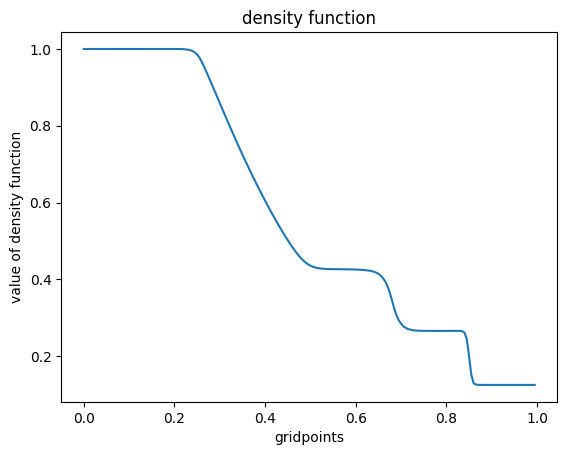

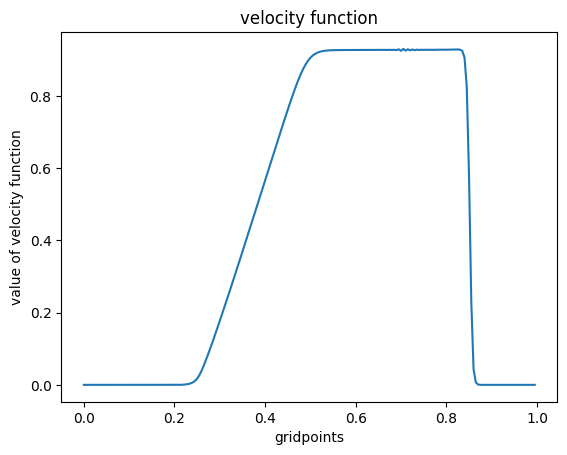

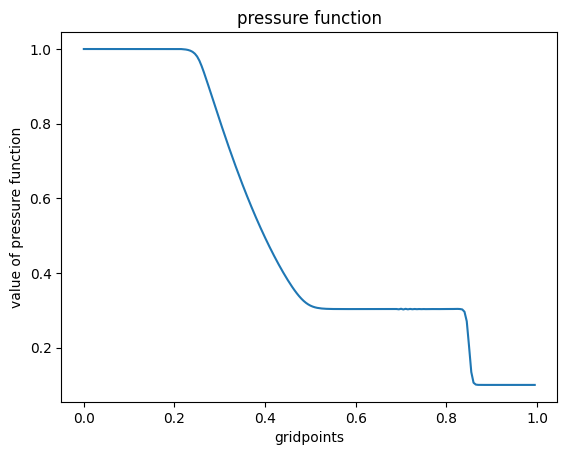

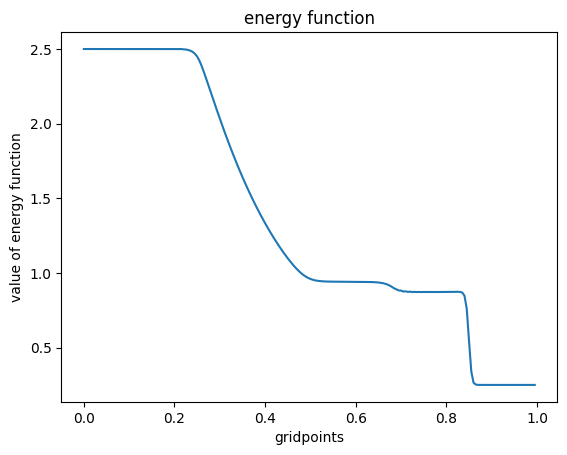

In [56]:
n = 200

def plot(vs, data, xlabel, ylabel, title):
    plt.figure()
    plt.plot(vs,data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

sod_ics = make_sod_ics(n)
print("Running solver... (takes about 5 s)")
sol = solve(sod_ics,"n",0.2)
print("Done!")
r, u, p, E = get_state_from_vec(sol)

vs = np.linspace(0,1,n,endpoint=False)

plot(vs,r,"gridpoints","value of density function","density function")

plot(vs,u,"gridpoints","value of velocity function","velocity function")

plot(vs,p,"gridpoints","value of pressure function","pressure function")

plot(vs,E,"gridpoints","value of energy function","energy function")

## Verifying accuracy on Advection

Finally we test that our solution on advection is third order accurate.
We'll divide the interval into 100, 200, and 400 points and then create a log plot of the errors obtained.
Accuracy is measured by the slope of the plot line and not by its absolute location in the graph. Running this next snippet should produce the expected slope and it should be visibly parallel to third order error, steeper than both order 1 and 2 even if it overlaps absolutely with any of them.
The time it takes depends roughly quadratically on grid spacing. On average the 100 points take 5 seconds, 200 points take 20 seconds, and 400 points take 80 seconds, for a total of about 2 minutes.

Solving when grid spacing is 100
Solving when grid spacing is 200
Solving when grid spacing is 400


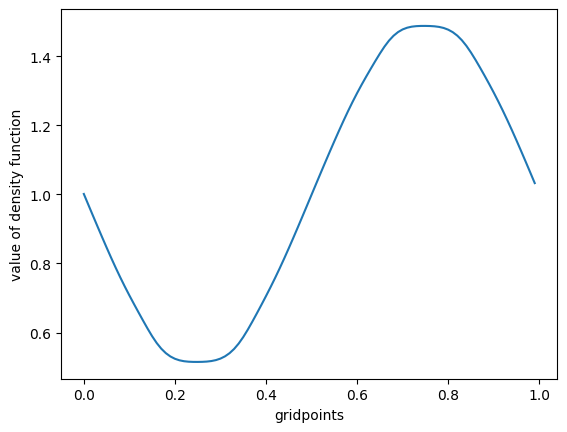

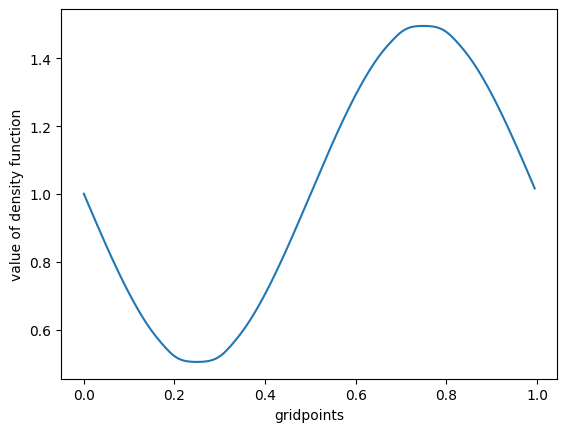

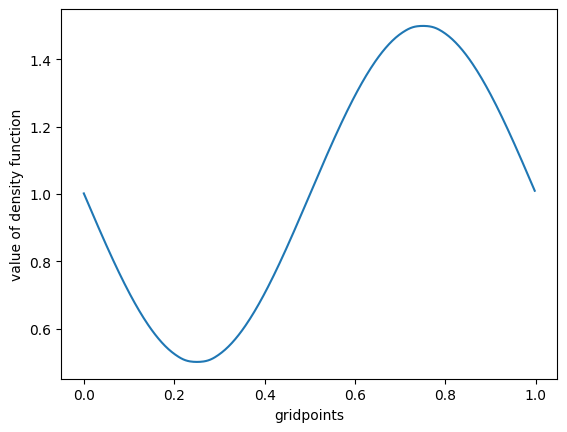

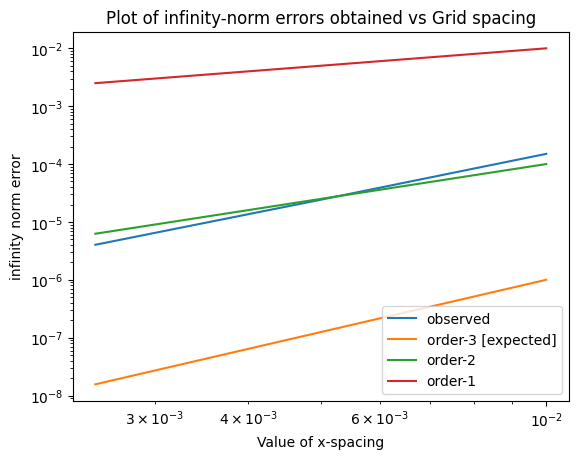

In [57]:
n = 100
hs = []
errs_inf = []
for i in range(3):
    p_ics = make_per_ics(n)
    print("Solving when grid spacing is " + str(n))
    sol = solve(p_ics,"p",0.5) #initial and exact should be the same in this case
    r = sol[0,:]
    r_e = p_ics[0,:]
    errs_inf.append(la.norm(r - (2.0-r_e),np.inf)*1.0/n) #after half a period, density is just 2 - initial
    vs = np.linspace(0,1,n,endpoint=False)
    plt.plot(vs,r)
    plt.xlabel("gridpoints")
    plt.ylabel("value of density function")
    plt.figure()
    hs.append(1.0/n)
    n = n*2


plt.loglog(hs,errs_inf, label="observed")
plt.loglog(hs,np.array(hs)**3,label="order-3 [expected]")
plt.loglog(hs,np.array(hs)**2,label="order-2")
plt.loglog(hs,np.array(hs),label="order-1")
plt.legend()
plt.xlabel("Value of x-spacing")
plt.ylabel("infinity norm error")
plt.title("Plot of infinity-norm errors obtained vs Grid spacing")
plt.show()